In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [2]:
# File paths
train_metadata_path = '/kaggle/input/isic-2024-challenge/train-metadata.csv'
test_metadata_path = '/kaggle/input/isic-2024-challenge/test-metadata.csv'

# Load metadata
train_metadata = pd.read_csv(train_metadata_path)
test_metadata = pd.read_csv(test_metadata_path)

train_metadata.head()

/tmp/ipykernel_19/3561205642.py:6: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_metadata = pd.read_csv(train_metadata_path)


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [3]:
# Check for missing values
missing_values = train_metadata.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 isic_id                              0
target                               0
patient_id                           0
age_approx                        2798
sex                              11517
anatom_site_general               5756
clin_size_long_diam_mm               0
image_type                           0
tbp_tile_type                        0
tbp_lv_A                             0
tbp_lv_Aext                          0
tbp_lv_B                             0
tbp_lv_Bext                          0
tbp_lv_C                             0
tbp_lv_Cext                          0
tbp_lv_H                             0
tbp_lv_Hext                          0
tbp_lv_L                             0
tbp_lv_Lext                          0
tbp_lv_areaMM2                       0
tbp_lv_area_perim_ratio              0
tbp_lv_color_std_mean                0
tbp_lv_deltaA                        0
tbp_lv_deltaB                        0
tbp_lv_deltaL                        0
tbp_lv_d

Some Columns have lot of NaN values (almost all values are null) which leads us into "curse of dimension". We will drop these columns

In [4]:
# List of columns to remove
columns_to_remove = ['lesion_id', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5', 'mel_mitotic_index', 'mel_thick_mm']

# Remove specified columns
train_metadata_cleaned = train_metadata.drop(columns=columns_to_remove, errors='ignore')

# Remove rows with any remaining null values
train_metadata_cleaned_no_nulls = train_metadata_cleaned.dropna()

In [5]:
# Check for 'target' column distribution
train_metadata_cleaned_no_nulls['target'].value_counts()

target
0    381533
1       381
Name: count, dtype: int64

In [6]:
# Separate majority and minority classes
majority_class = train_metadata_cleaned_no_nulls[train_metadata_cleaned_no_nulls['target'] == 0]
minority_class = train_metadata_cleaned_no_nulls[train_metadata_cleaned_no_nulls['target'] == 1]

# Downsample majority class to match minority class size
majority_class_downsampled = resample(majority_class,
                                      replace=False,  # Sample without replacement
                                      n_samples=len(minority_class),  # Match minority class size
                                      random_state=42)  # For reproducibility

# Combine minority class with downsampled majority class
train_metadata_balanced = pd.concat([majority_class_downsampled, minority_class])

# Display the shape and class distribution of the balanced DataFrame
print("Shape after balancing classes:", train_metadata_balanced.shape)
print("Class Distribution after balancing:\n", train_metadata_balanced['target'].value_counts())

Shape after balancing classes: (762, 48)
Class Distribution after balancing:
 target
0    381
1    381
Name: count, dtype: int64


In [7]:
train_metadata_balanced.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license,iddx_full,iddx_1,tbp_lv_dnn_lesion_confidence
44730,ISIC_1176500,0,IP_4013104,50.0,female,posterior torso,3.35,TBP tile: close-up,3D: white,21.195278,...,0.726667,60,-103.079308,1195.573975,227.486694,Memorial Sloan Kettering Cancer Center,CC-BY,Benign,Benign,99.990058
362429,ISIC_9047349,0,IP_9057861,80.0,male,lower extremity,2.82,TBP tile: close-up,3D: white,17.323980,...,0.460432,110,-170.181000,764.250000,29.220830,Memorial Sloan Kettering Cancer Center,CC-BY,Benign,Benign,99.999270
17389,ISIC_0500366,0,IP_6894380,45.0,female,posterior torso,4.81,TBP tile: close-up,3D: white,19.021500,...,0.207865,15,66.219480,1457.846000,78.279170,Memorial Sloan Kettering Cancer Center,CC-BY,Benign,Benign,99.999990
367815,ISIC_9176171,0,IP_6422845,70.0,male,posterior torso,4.19,TBP tile: close-up,3D: white,19.501620,...,0.334615,55,-39.389570,1057.866000,169.172800,Memorial Sloan Kettering Cancer Center,CC-BY,Benign,Benign,99.997030
192982,ISIC_4857877,0,IP_7331742,65.0,male,lower extremity,2.52,TBP tile: close-up,3D: XP,21.714430,...,0.185185,55,-150.631100,749.153000,-3.548462,"Department of Dermatology, Hospital Clínic de ...",CC-BY-NC,Benign,Benign,99.999950


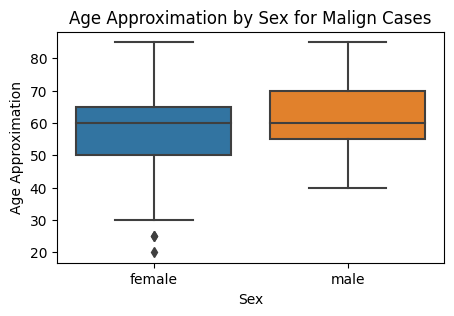

In [8]:
# Filter the DataFrame for target = 1 (malign)
filtered_data = train_metadata_balanced[train_metadata_balanced['target'] == 1]

# Create the plot
plt.figure(figsize=(5, 3))
sns.boxplot(x='sex', y='age_approx', data=filtered_data)
plt.title('Age Approximation by Sex for Malign Cases')
plt.xlabel('Sex')
plt.ylabel('Age Approximation')
plt.show()

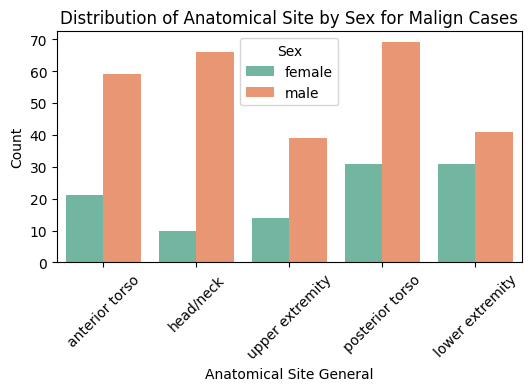

In [9]:
# Create the plot
plt.figure(figsize=(6, 3))
sns.countplot(x='anatom_site_general', hue='sex', data=filtered_data, palette='Set2')
plt.title('Distribution of Anatomical Site by Sex for Malign Cases')
plt.xlabel('Anatomical Site General')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sex')
plt.show()

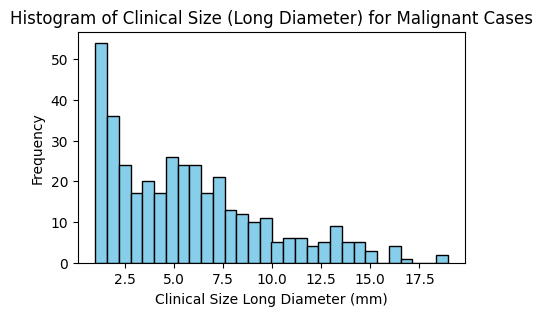

In [10]:
# Plot histogram for 'clin_size_long_diam_mm'
plt.figure(figsize=(5, 3))
plt.hist(filtered_data['clin_size_long_diam_mm'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Clinical Size (Long Diameter) for Malignant Cases')
plt.xlabel('Clinical Size Long Diameter (mm)')
plt.ylabel('Frequency')
plt.show()

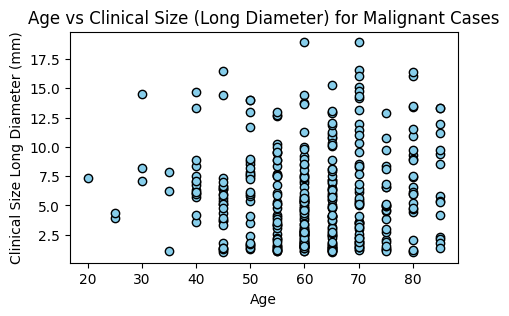

In [11]:
# Plot age_approx vs clin_size_long_diam_mm
plt.figure(figsize=(5, 3))
plt.scatter(filtered_data['age_approx'], filtered_data['clin_size_long_diam_mm'], color='skyblue', edgecolor='black')
plt.title('Age vs Clinical Size (Long Diameter) for Malignant Cases')
plt.xlabel('Age')
plt.ylabel('Clinical Size Long Diameter (mm)')
plt.show()

In [12]:
# Encode 'sex' column: 1 for male and 0 for female
train_metadata_balanced['sex'] = train_metadata_balanced['sex'].map({'male': 1, 'female': 0})

In [13]:
# Encode 'anatom_site_mapping' column
anatom_site_mapping = {
    'posterior torso': 1,
    'lower extremity': 2,
    'anterior torso': 3,
    'upper extremity': 4,
    'head/neck': 5
}
# Apply the mapping, assigning 0 to any values not in the mapping
train_metadata_balanced['anatom_site_general'] = train_metadata_balanced['anatom_site_general'].apply(
    lambda x: anatom_site_mapping.get(x, 0)
)

In [14]:
# Encode 'tbp_lv_location' column
tbp_lv_location_mapping = {
    'Torso Front Top Half': 1,
    'Torso Back Top Third': 2,
    'Head & Neck': 3,
    'Torso Back Middle Third': 4,
    'Left Leg - Lower': 5,
    'Right Leg - Lower': 6,
    'Torso Front Bottom Half': 7,
    'Left Arm - Upper': 8,
    'Left Leg - Upper': 9,
    'Right Arm - Upper': 10,
    'Right Leg - Upper': 11,
    'Left Arm - Lower': 12,
    'Right Arm - Lower': 13,
    'Torso Back Bottom Third': 14,
    'Left Leg': 15,
    'Right Leg': 16,
    'Left Arm': 17,
    'Right Arm': 18
}
# Apply the mapping, assigning 0 to any values not in the mapping
train_metadata_balanced['tbp_lv_location'] = train_metadata_balanced['tbp_lv_location'].apply(
    lambda x: tbp_lv_location_mapping.get(x, 0)
)

In [15]:
# Encode 'tbp_lv_location_simple' column
tbp_lv_location_simple_mapping = {
    'Torso Back': 1,
    'Torso Front': 2,
    'Left Leg': 3,
    'Head & Neck': 4,
    'Right Leg': 5,
    'Left Arm': 6,
    'Right Arm': 7
}
# Apply the mapping, assigning 0 to any values not in the mapping
train_metadata_balanced['tbp_lv_location_simple'] = train_metadata_balanced['tbp_lv_location_simple'].apply(
    lambda x: tbp_lv_location_simple_mapping.get(x, 0)
)

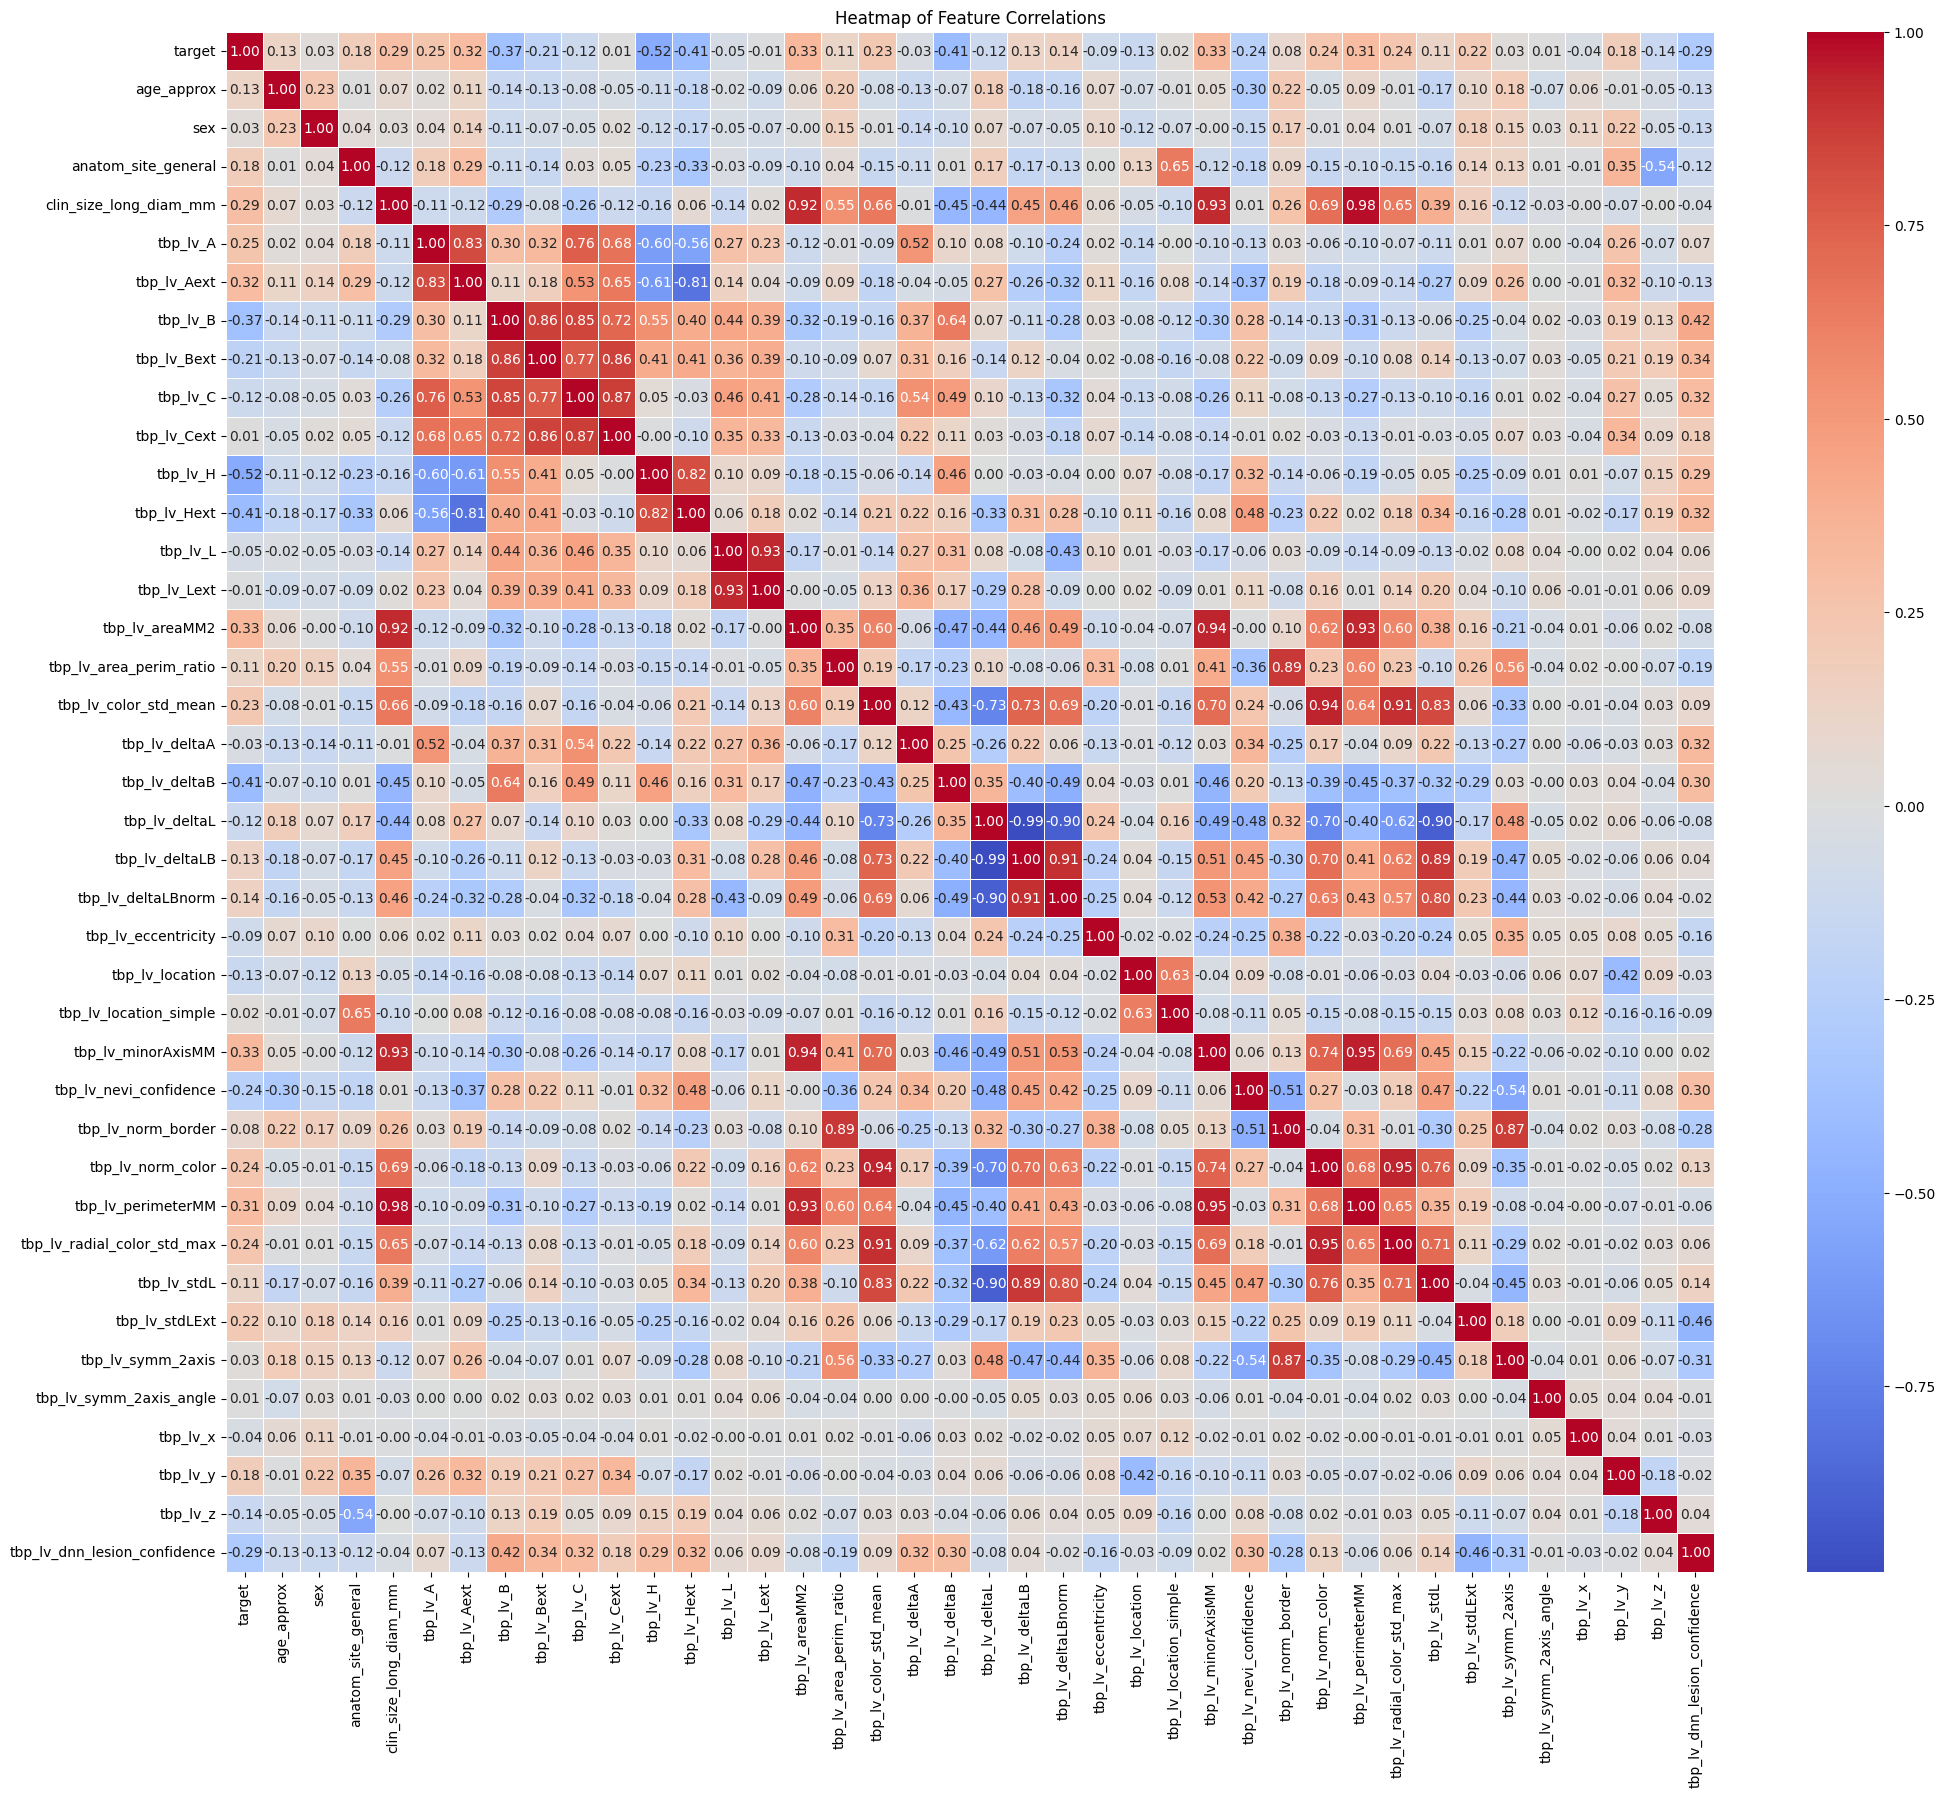

In [16]:
# Create a heatmap
data_for_heatmap = train_metadata_balanced.drop(columns=['isic_id', 'patient_id', 'image_type', 'tbp_tile_type', 'attribution', 'copyright_license', 'iddx_full', 'iddx_1'])
plt.figure(figsize=(24, 20))
sns.heatmap(data_for_heatmap.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap of Feature Correlations')
plt.show()

In [17]:
X = train_metadata_balanced.drop(columns=['isic_id', 'target', 'patient_id', 'image_type', 'tbp_tile_type', 'attribution', 'copyright_license', 'iddx_full', 'iddx_1', 'tbp_lv_dnn_lesion_confidence'])
y = train_metadata_balanced['target']

In [18]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [19]:
# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)  # Ensure y has shape (N, 1)

In [20]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

In [21]:
# Create DataLoaders
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [22]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation to get probabilities

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Initialize model
input_dim = X_tensor.shape[1]
model = SimpleNN(input_dim)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [23]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
        val_loss /= len(val_loader)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}')

Epoch 1/20, Validation Loss: 0.6784
Epoch 2/20, Validation Loss: 0.6503
Epoch 3/20, Validation Loss: 0.6151
Epoch 4/20, Validation Loss: 0.5688
Epoch 5/20, Validation Loss: 0.5199
Epoch 6/20, Validation Loss: 0.4811
Epoch 7/20, Validation Loss: 0.4633
Epoch 8/20, Validation Loss: 0.4586
Epoch 9/20, Validation Loss: 0.4587
Epoch 10/20, Validation Loss: 0.4561
Epoch 11/20, Validation Loss: 0.4548
Epoch 12/20, Validation Loss: 0.4608
Epoch 13/20, Validation Loss: 0.4573
Epoch 14/20, Validation Loss: 0.4546
Epoch 15/20, Validation Loss: 0.4554
Epoch 16/20, Validation Loss: 0.4589
Epoch 17/20, Validation Loss: 0.4506
Epoch 18/20, Validation Loss: 0.4491
Epoch 19/20, Validation Loss: 0.4539
Epoch 20/20, Validation Loss: 0.4575


In [24]:
# Evaluate the model
model.eval()
with torch.no_grad():
    y_true = []
    y_pred = []
    for X_batch, y_batch in val_loader:
        outputs = model(X_batch)
        predictions = (outputs > 0.5).float()
        y_true.extend(y_batch.numpy())
        y_pred.extend(predictions.numpy())

# Convert lists to numpy arrays for metrics calculations
y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc:.4f}')

Accuracy: 0.7843
Precision: 0.7805
Recall: 0.8101
F1 Score: 0.7950
ROC AUC Score: 0.7834


In [25]:
test_metadata.head()

,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY
2,ISIC_0015740,IP_7142616,65.0,male,posterior torso,3.16,TBP tile: close-up,3D: XP,24.25384,19.937380,...,0.230742,1.080308,2.705857,0.366071,110,-84.29282,1303.978000,-28.576050,FNQH Cairns,CC-BY


In [26]:
# Drop the same columns as in the training data
test_metadata_cleaned = test_metadata.drop(columns=columns_to_remove, errors='ignore')

In [27]:
# Encode 'sex' column
test_metadata_cleaned['sex'] = test_metadata_cleaned['sex'].map({'male': 1, 'female': 0})

# Encode 'anatom_site_general' column
test_metadata_cleaned['anatom_site_general'] = test_metadata_cleaned['anatom_site_general'].apply(
    lambda x: anatom_site_mapping.get(x, 0)
)

# Encode 'tbp_lv_location' column
test_metadata_cleaned['tbp_lv_location'] = test_metadata_cleaned['tbp_lv_location'].apply(
    lambda x: tbp_lv_location_mapping.get(x, 0)
)

# Encode 'tbp_lv_location_simple' column
test_metadata_cleaned['tbp_lv_location_simple'] = test_metadata_cleaned['tbp_lv_location_simple'].apply(
    lambda x: tbp_lv_location_simple_mapping.get(x, 0)
)

In [28]:
X_test = test_metadata_cleaned.drop(columns=['isic_id', 'patient_id', 'image_type', 'tbp_tile_type', 'attribution', 'copyright_license'])

In [29]:
# Scale features using the same scaler fitted on training data
X_test_scaled = scaler.transform(X_test)

In [30]:
# Convert to PyTorch tensor
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

In [31]:
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    predictions = model(X_test_tensor)
    predicted_labels = (predictions > 0.5).float().numpy()  # Convert probabilities to binary labels

In [32]:
# Create a DataFrame for submission
submission = pd.DataFrame({
    'isic_id': test_metadata['isic_id'],  # Assuming 'isic_id' is the unique identifier in test data
    'target': predicted_labels.flatten()  # Flatten to match the format
})

# Save to CSV
submission.to_csv('submission.csv', index=False)